# Applying ALS methods as collaborative filtering approach for yelp dataset
In the follwoing, we use review dataset of yelp to create the sparse matrix and apply ALS approach to recommend restaurant to the users.

## Importing required libraries

In [14]:
import os
import sys
from pyspark.rdd import RDD
from pyspark.sql import Row
from pyspark.sql import DataFrame
from pyspark.sql import SparkSession
#add the following two in order to use avg
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.sql.functions import lit
from pyspark.sql.functions import desc
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer
import matplotlib.pyplot as plt


## Initializing Spark to use its dataframe as the main datastructure.

In [2]:
# Initialize a spark session.
def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Python Spark SQL basic example") \
        .config("spark.some.config.option", "some-value") \
        .getOrCreate()
    return spark

In [3]:
spark = init_spark() # Initializate spark

## Reading data from the source files
In this part, we use review, user, business dataset. The main dataset that we are working on is the review.json but we use other two datasets to preprocess the data. With business dataset, we filter the businesses which are related to the restaurants and with the user dataset, we filter the users which contains less than 10 reviews.

In [4]:
#reading the review dataset and spilling on pyspark dataframe
path = 'data/yelp_academic_dataset_review.json'
df_review = spark.read.json(path).limit(500000)
# df_review = spark.read.json(path)

In [5]:
#reading the buisiness dataset and spilling on pyspark dataframe
path = 'data/yelp_academic_dataset_business.json'
df_business = spark.read.json(path)

In [6]:
#reading the user dataset and spilling on pyspark dataframe
path = 'data/yelp_academic_dataset_user.json'
df_user = spark.read.json(path)
df_user = df_user.select('user_id', 'review_count')

### 1. filter the users with more than 10 reviews.

In [7]:
#filter the users with more than 10 review counts
df_user = df_user.filter(col('review_count')>=10)

In [8]:
#we need userId, businessId and ratings for ALS
df_review = df_review[['user_id','business_id','stars']]

In [9]:
#Apply on review dataset
df_review = df_review.join(df_user, df_review.user_id == df_user.user_id ,"left_semi")

### 2. Filter the restaurant businesses

In [10]:
#filter restaurant businesses 
df_business = df_business.filter(df_business.categories.contains('Restaurants'))

In [11]:
df_review = df_review.join(df_business[['business_id']], 
                             df_review.business_id == df_business.business_id ,"left_semi")

Dropping out these two DataFrame to manage memory and speedup the process.

In [12]:
df_business.unpersist()
df_user.unpersist()

DataFrame[user_id: string, review_count: bigint]

The following plot shows how ratings have been distributed among the descrete numbers.

In [12]:
list_rating =  [row[0] for row in df_review.select('stars').collect()]

Text(0, 0.5, 'Number of each rate')

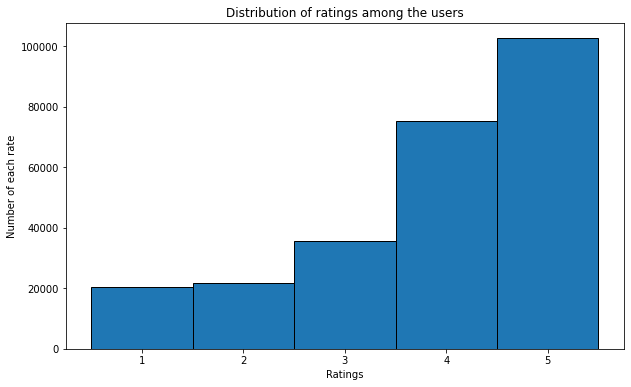

In [24]:
fig = plt.figure(figsize=(10,6))
plt.hist(list_rating, bins=[0.5,1.5,2.5,3.5,4.5,5.5], edgecolor='black')
plt.title('Distribution of ratings among the users')
plt.xlabel('Ratings')
plt.ylabel('Number of each rate')

### 3. ALS works with user and business ID in numerical format.
So here we are converting the user and business ID to the numerical format.

In [13]:
indexers = [StringIndexer(inputCol=column, outputCol=column+"_index").fit(df_review) 
            for column in list(set(df_review.columns)-set(['stars'])) ]


pipeline = Pipeline(stages=indexers)
df_review = pipeline.fit(df_review).transform(df_review)

# df_review.show()

In [14]:
print(df_review.select('user_id').distinct().count())
print(df_review.select('user_id').count())

146462
255679


### Check RMSE and MAE when the prediction is global average

In [15]:
(df_train, df_test) = df_review.randomSplit([0.8, 0.2], seed=0)

In [16]:
eval_rmse = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="glb_average")
eval_mae = RegressionEvaluator(metricName="mae", labelCol="stars", predictionCol="glb_average")

In [17]:
glb_average = df_train.select(avg('stars')).collect()[0][0] 
df_test = df_test.withColumn('glb_average', lit(glb_average))
rmse = eval_rmse.evaluate(df_test)
mae = eval_mae.evaluate(df_test)
print("RMSE for global average = %.3f"%rmse)
print("MAE for global average = %.3f"%mae)

RMSE for global average = 1.248
MAE for global average = 1.003


We use validation in training set to choose the best set of hyperparameters for the dataset. Then we apply the best set to test dataset.

In [18]:
eval_rmse = RegressionEvaluator(metricName="rmse", labelCol="stars", predictionCol="prediction")
eval_mae = RegressionEvaluator(metricName="mae", labelCol="stars", predictionCol="prediction")

In [19]:
#create evaluator object
maxIter = [17]
regParam = [0.4,0.6]
rank = [10,20,50]
#create the als model
als = ALS(userCol="user_id_index", 
          itemCol="business_id_index", 
          ratingCol="stars",seed=0, nonnegative=True, coldStartStrategy="drop")

#we use a ParamGridBuilder to construct a grid of parameters to search over.
#trainValidationSplit will try all combinations of values and determine best model using the evaluator.
paramGrid = ParamGridBuilder()\
    .addGrid(als.regParam, regParam) \
    .addGrid(als.maxIter, maxIter)\
    .addGrid(als.rank, rank)\
    .build()

#in this case the estimator is ALS.
#a TrainValidationSplit requires an Estimator, a set of Estimator ParamMaps, and an Evaluator.
tvs = TrainValidationSplit(estimator=als,
                           estimatorParamMaps=paramGrid,
                           evaluator=eval_rmse,
                           # 80% of the data will be used for training, 20% for validation.
                           trainRatio=0.8)

# Run TrainValidationSplit, and choose the best set of parameters.
model = tvs.fit(df_train)

### RMSE and MAE when the predicition is done by the model

In [20]:
#make predictions on test data. model is the model with combination of parameters
#that performed best.
prediction = model.transform(df_test)
rmse = eval_rmse.evaluate(prediction)
mae = eval_mae.evaluate(prediction)
print("RMSE for the model = %.3f"%rmse)
print("MAE for the model = %.3f"%mae)

RMSE for the model = 1.409
MAE for the model = 1.125
